# Objective : Understand how feature transforms take place

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

Mounted at /content/drive


In [2]:
# import raw data and params.txt file

datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"
raw_data = load_data(path=datadir_path,as_df=False)
params_data = load_params(path=datadir_path)
# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading data into numpy array. Took 16.97s
Finsihed loading parameters file


In [3]:
print(raw_data.shape)
offset = 150
shifted_data, center = get_window(raw_data,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 942)
The Echo pulse occurs at timestep: 628


In [4]:
rscl_df = pd.DataFrame(rscl_data, columns=[f"F{i}" for i in range(len(rscl_data[0]))])
rscl_df.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39,...,F260,F261,F262,F263,F264,F265,F266,F267,F268,F269,F270,F271,F272,F273,F274,F275,F276,F277,F278,F279,F280,F281,F282,F283,F284,F285,F286,F287,F288,F289,F290,F291,F292,F293,F294,F295,F296,F297,F298,F299
0,0.007752,0.007970,0.007859,0.007362,0.006486,0.005304,0.003966,0.002714,0.001994,0.002240,0.003050,0.003977,0.004912,0.005853,0.006821,0.007831,0.008886,0.009962,0.010987,0.011842,0.012395,0.012538,0.012233,0.011535,0.010597,0.009640,0.008909,0.008615,0.008896,0.009777,0.011158,0.012818,0.014456,0.015753,0.016443,0.016368,0.015518,0.014031,0.012173,0.010274,...,0.007232,0.008779,0.010651,0.012499,0.013974,0.014804,0.014843,0.014102,0.012740,0.011034,0.009314,0.007892,0.007006,0.006765,0.007147,0.008007,0.009117,0.010217,0.011072,0.011524,0.011516,0.011093,0.010370,0.009490,0.008576,0.007702,0.006896,0.006155,0.005456,0.004751,0.003979,0.003113,0.002297,0.002097,0.002921,0.004195,0.005431,0.006386,0.006943,0.007078
1,0.007954,0.008204,0.008141,0.007703,0.006886,0.005750,0.004428,0.003127,0.002203,0.002156,0.002860,0.003798,0.004777,0.005768,0.006779,0.007827,0.008917,0.010024,0.011077,0.011962,0.012546,0.012728,0.012472,0.011835,0.010966,0.010080,0.009416,0.009176,0.009490,0.010383,0.011755,0.013390,0.014990,0.016243,0.016885,0.016765,0.015876,0.014360,0.012483,0.010577,...,0.007048,0.008521,0.010312,0.012065,0.013431,0.014139,0.014050,0.013184,0.011710,0.009914,0.008133,0.006691,0.005825,0.005651,0.006139,0.007133,0.008391,0.009640,0.010638,0.011223,0.011338,0.011026,0.010407,0.009622,0.008794,0.007998,0.007270,0.006617,0.006022,0.005428,0.004746,0.003904,0.002948,0.002241,0.002522,0.003646,0.004908,0.005939,0.006574,0.006770
2,0.008362,0.008377,0.008070,0.007380,0.006320,0.005004,0.003705,0.002974,0.003336,0.004407,0.005636,0.006833,0.007985,0.009136,0.010327,0.011577,0.012878,0.014184,0.015409,0.016428,0.017104,0.017328,0.017059,0.016351,0.015362,0.014322,0.013497,0.013124,0.013367,0.014270,0.015734,0.017530,0.019332,0.020792,0.021610,0.021597,0.020720,0.019109,0.017034,0.014844,...,0.006680,0.004955,0.003161,0.002609,0.003653,0.004712,0.005075,0.004610,0.003449,0.001902,0.000592,0.001249,0.001900,0.001845,0.001082,0.000412,0.001964,0.003593,0.004948,0.005842,0.006216,0.006138,0.005770,0.005298,0.004852,0.004459,0.004079,0.003681,0.003262,0.002817,0.002313,0.001764,0.001522,0.002185,0.003444,0.004810,0.005980,0.006746,0.006991,0.006697
3,0.071041,0.116141,0.157928,0.186144,0.193928,0.176297,0.131342,0.063197,0.047574,0.143523,0.244109,0.331524,0.394783,0.427744,0.430725,0.411673,0.385972,0.372340,0.382148,0.410700,0.443466,0.467947,0.478935,0.478557,0.474363,0.476278,0.492618,0.526711,0.576429,0.636274,0.699532,0.759315,0.808905,0.842098,0.853650,0.839802,0.798746,0.730959,0.639387,0.529448,...,0.235294,0.135007,0.063859,0.099112,0.173708,0.244687,0.307738,0.362627,0.409473,0.448187,0.478734,0.501774,0.519287,0.534609,0.551404,0.571638,0.593824,0.613037,0.622808,0.617796,0.595924,0.559370,0.514321,0.469429,0.433229,0.411235,0.404521,0.410693,0.425682,0.444243,0.459769,0.464925,0.453342,0.421539,0.370215,0.304493,0.233116,0.166677,0.114716,0.081142
4,0.008419,0.008817,0.008915,0.008637,0.007955,0.006909,0.005599,0.004194,0.002949,0.002305,0.002617,0.003497,0.004533,0.005599,0.006677,0.007779,0.008908,0.010039,0.011106,0.012004,0.012620,0.012869,0.012727,0.012255,0.011597,0.010952,0.010531,0.010513,0.011006,0.012017,0.013439,0.015058,0.016584,0.017720,0.018223,0.017961,0.016947,0.015341,0.013419,0.011513,...,0.006159,0.007627,0.009420,0.011146,0.012434,0.013009,0.012752,0.011716,0.010124,0.008314,0.006670,0.005512,0.004990,0.005112,0.005866,0.007183,0.008842,0.010533,0.011964,0.012934,0.013360,0.013272,0.012779,0.012017,0.011110,0.010155,0.009230,0.008404,0.007718,0.007137,0.006539,0.005765,0.004723,0.003468,0.002375,0.002367,0.003448,0.004673,0.005620,0.006170


In [5]:
stats = rscl_df.describe().T.round(3)
stats.head(10)

,count,mean,std,min,25%,50%,75%,max
F0,10500.0,0.022,0.045,0.000,0.008,0.010,0.015,0.622
F1,10500.0,0.024,0.045,0.000,0.008,0.011,0.018,0.605
F2,10500.0,0.026,0.046,0.000,0.008,0.012,0.021,0.572
F3,10500.0,0.028,0.046,0.000,0.008,0.012,0.024,0.599
F4,10500.0,0.030,0.048,0.000,0.008,0.012,0.027,0.600
F5,10500.0,0.031,0.049,0.000,0.007,0.012,0.029,0.579
F6,10500.0,0.031,0.051,0.000,0.006,0.011,0.029,0.534
F7,10500.0,0.030,0.050,0.000,0.005,0.010,0.028,0.468
F8,10500.0,0.028,0.048,0.001,0.004,0.009,0.026,0.423
F9,10500.0,0.025,0.044,0.000,0.004,0.008,0.022,0.450


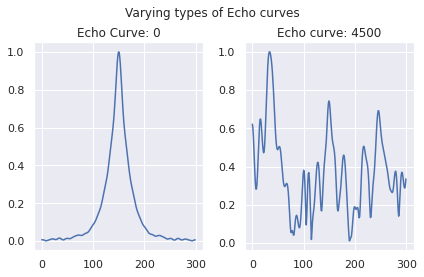

In [6]:
plt.subplot(121)
plt.plot(rscl_df.iloc[0,:].values)
plt.title("Echo Curve: 0")
plt.subplot(122)
a = rscl_df[rscl_df['F0'] == rscl_df['F0'].max()].values #occurs in stencil = 1
plt.plot(a.flatten())
plt.title(f"Echo curve: {rscl_df[rscl_df['F0'] == rscl_df['F0'].max()].index[0]}")
plt.suptitle("Varying types of Echo curves")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

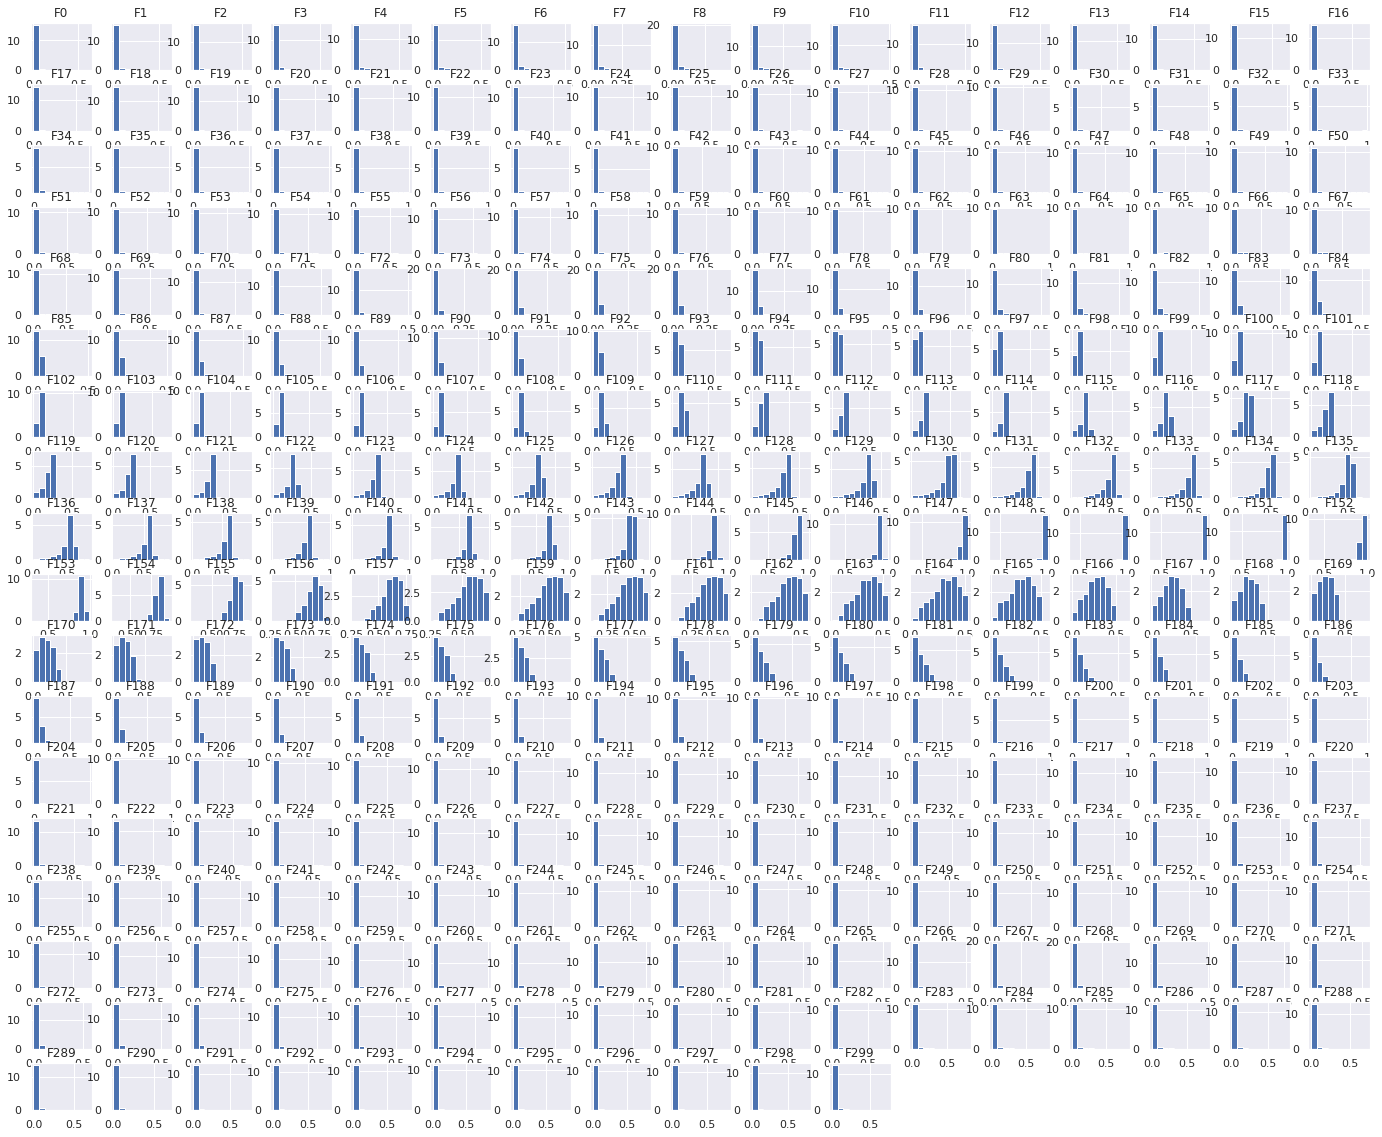

In [7]:
### AVOID RUNNING UNLESS REQUIRED
# Plots a histogram plot for each column (time-consuming! ) 
rscl_df.hist(figsize=(24, 20), density=True)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
#plt.tight_layout()
plt.show()

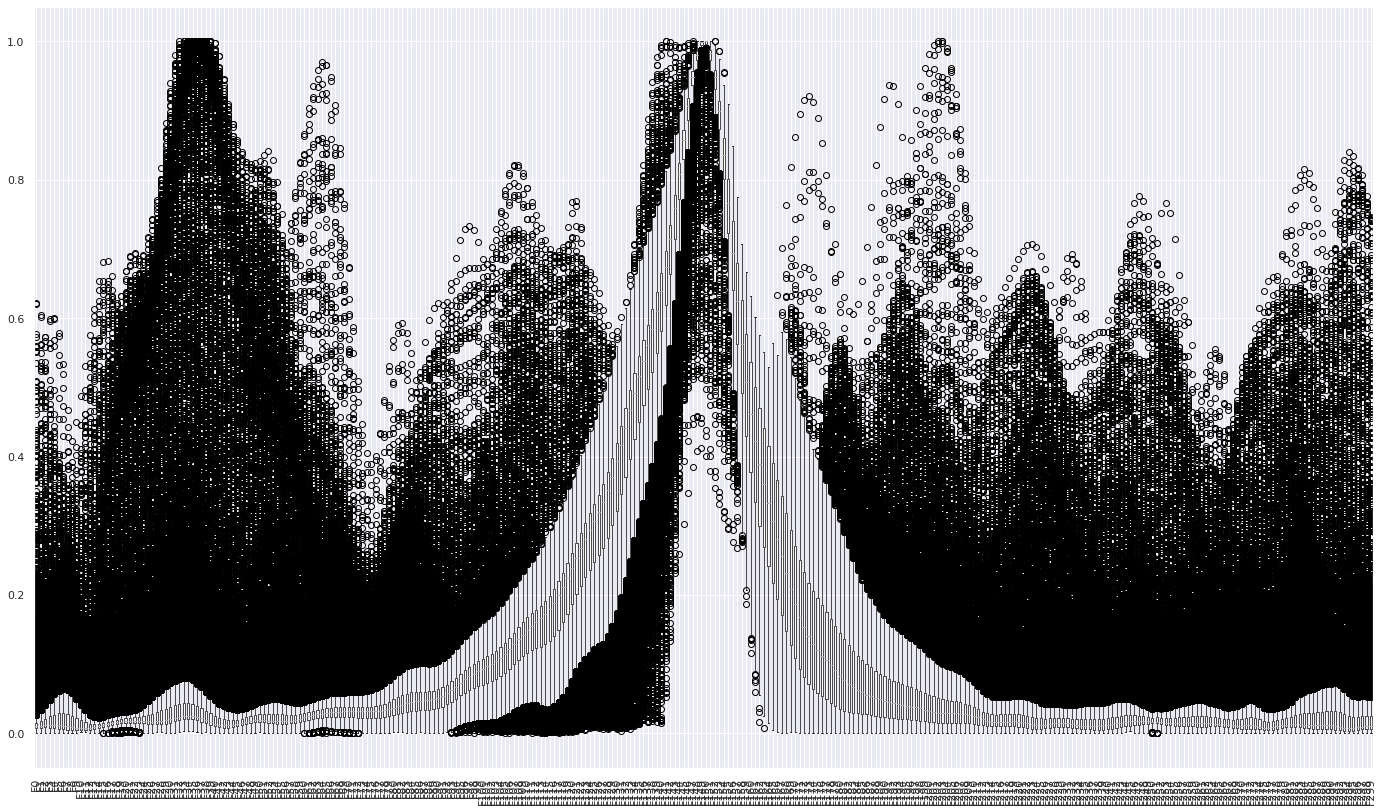

In [8]:
### AVOID RUNNING UNLESS REQUIRED
# Plots a box-plot for each column (time-consuming! ) 
rscl_df.boxplot(figsize=(24, 14))
plt.xticks(rotation=90)
plt.show()

## Exploratory analysis 

Q : What does a PowerTransformer and a QuantileTransformer do?


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import ( PowerTransformer, QuantileTransformer,
StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer )

In [19]:
X_train, X_test, y_train, y_test = train_test_split(rscl_data, params_data['stencil_type'].values,
                                                    test_size=0.30, random_state=42)
X_train_df = pd.DataFrame(X_train, columns = [f"F{i}" for i in range(len(rscl_data[0]))])

In [20]:
def transform_and_plot(data, transformer, want_cols):
    for counter, col in enumerate(X_train_df.columns[range(want_cols[0],want_cols[1],want_cols[2])]):
        plot_transform(data, col, transformer)
        
def plot_transform(df, col, transformer):
    plt.figure(figsize=(8,6))
    plt.subplot(121)
    sns.kdeplot(df[col].values.flatten())
    plt.title("Before"+str(transformer).split('(')[0]+f"on {col}")

    plt.subplot(122)
    p1 = transformer.fit_transform((df[col].values).reshape(-1, 1))
    sns.kdeplot(p1.flatten())
    plt.title("After"+str(transformer).split('(')[0]+f"on {col}")

In [21]:
transformers = [PowerTransformer(method='box-cox'), 
                QuantileTransformer(output_distribution='normal'), 
                FunctionTransformer(np.log)]

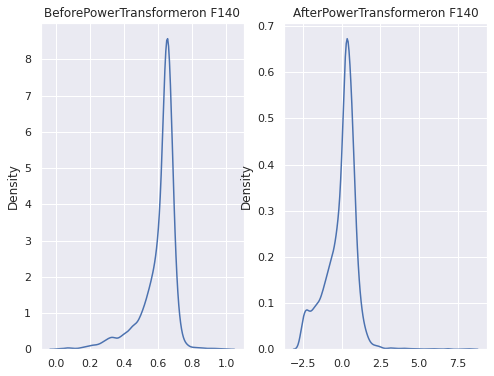

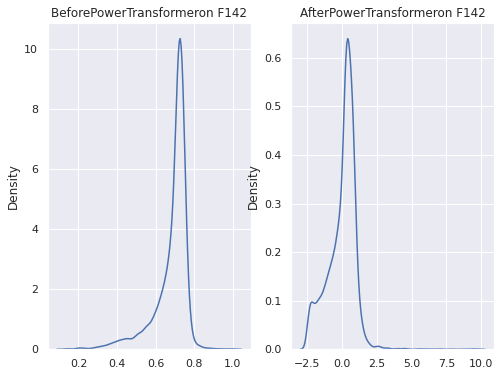

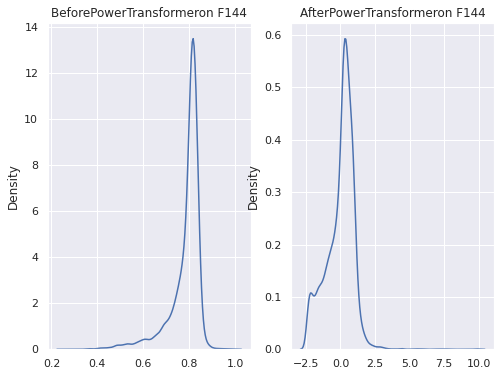

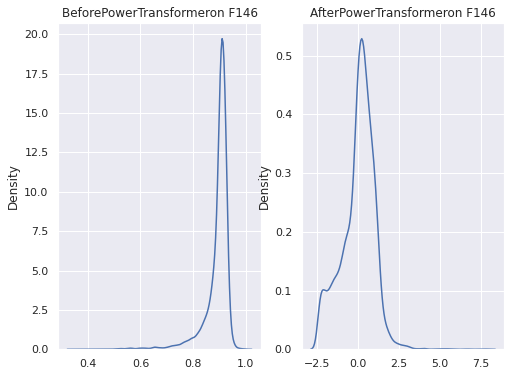

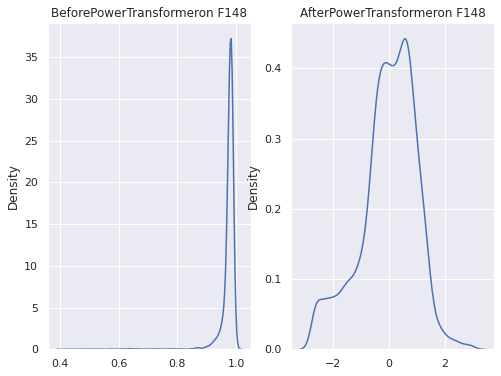

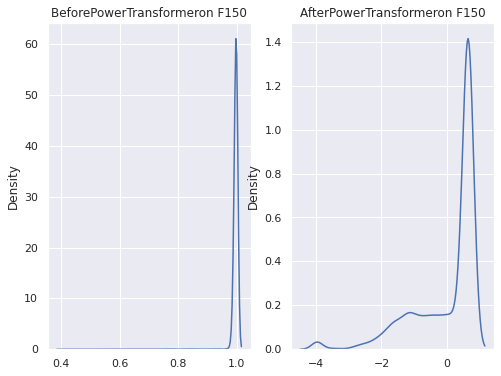

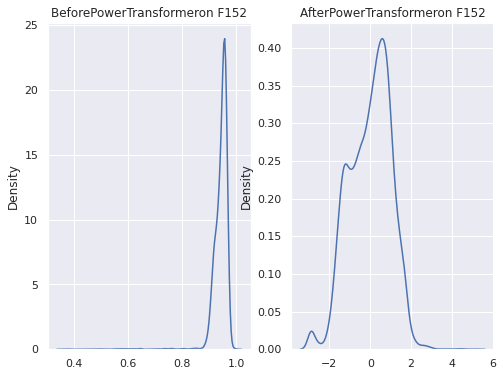

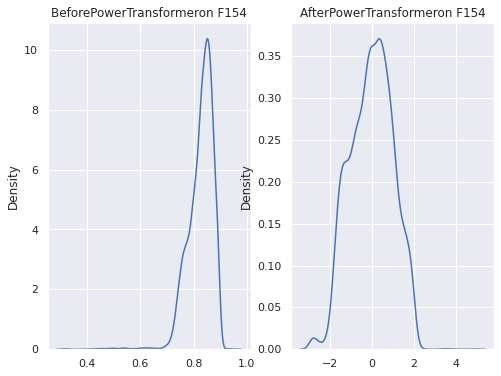

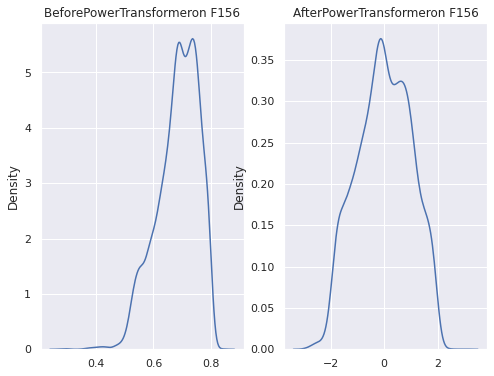

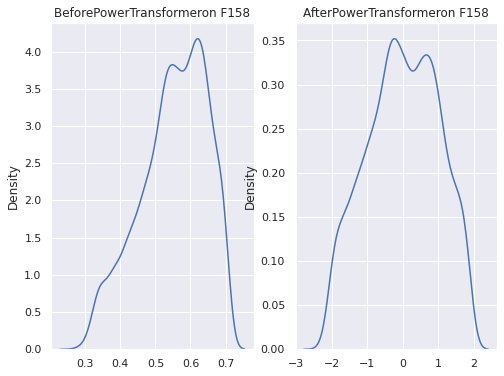

In [22]:
#PowerTranformer
transform_and_plot(X_train_df, transformers[0], [140,160,2])

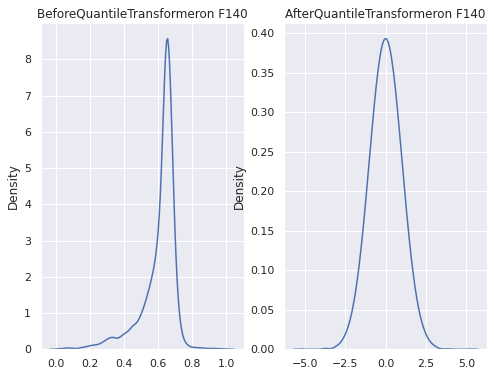

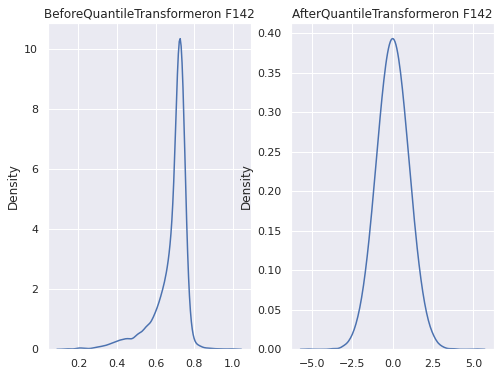

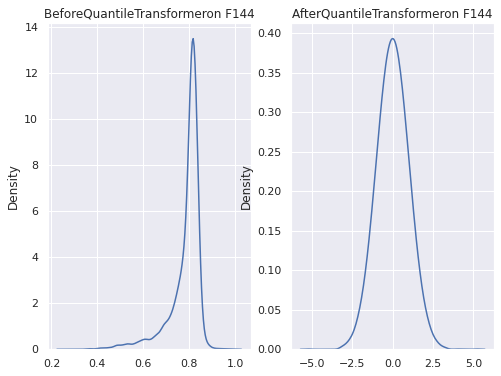

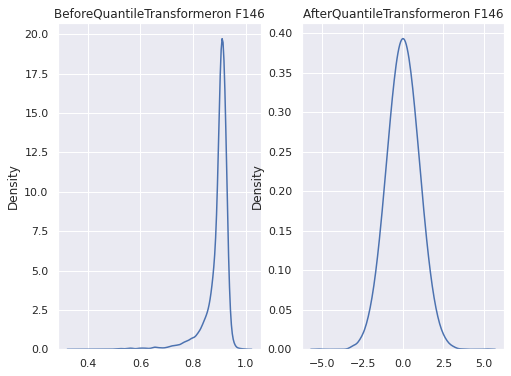

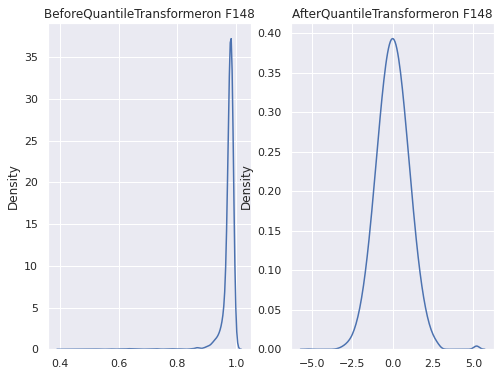

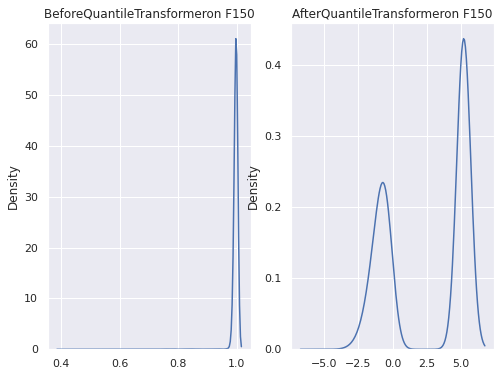

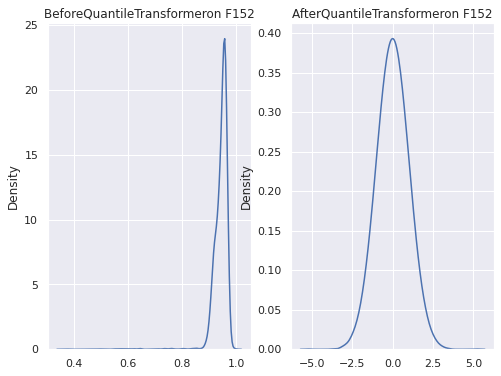

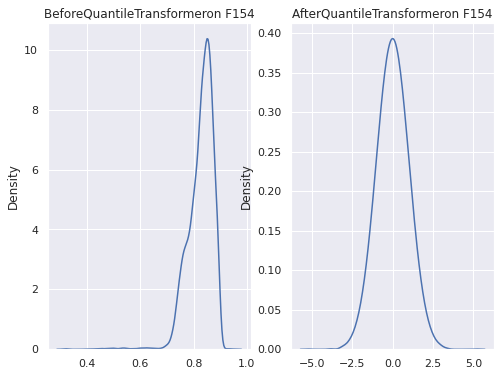

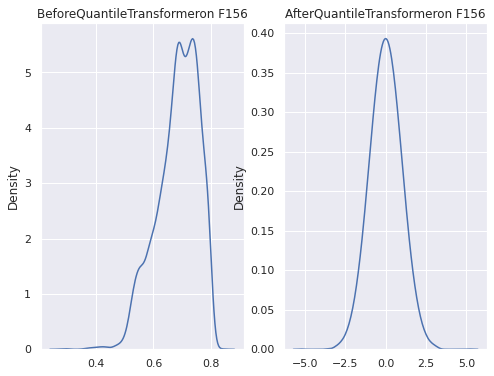

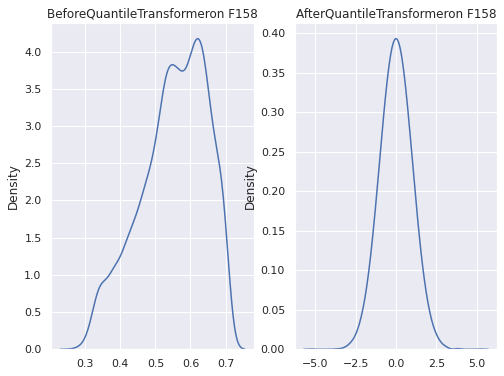

In [24]:
#Quantile Tranformer (Feature 150 looks interesting !)
transform_and_plot(X_train_df, transformers[1], [140,160,2])

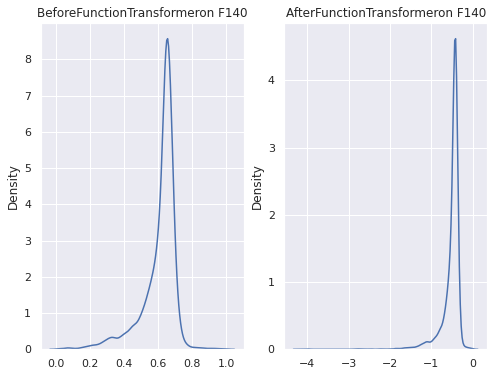

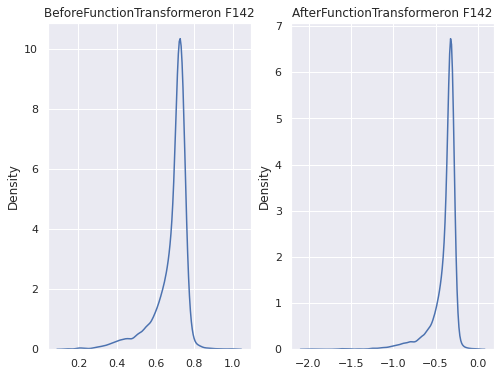

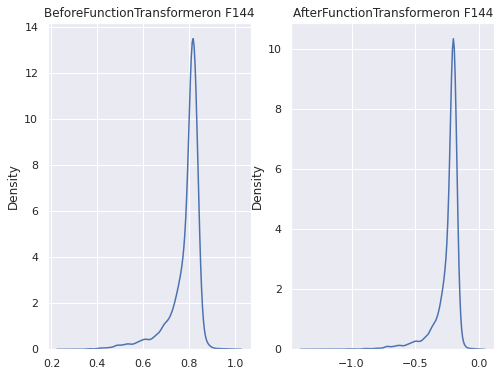

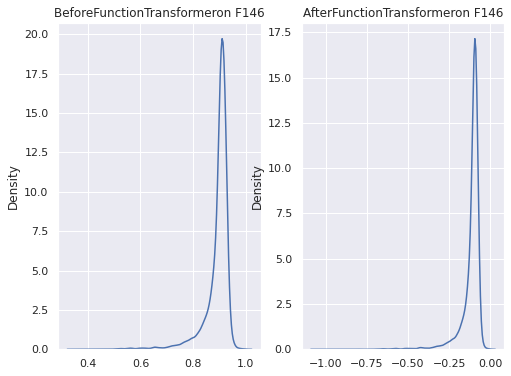

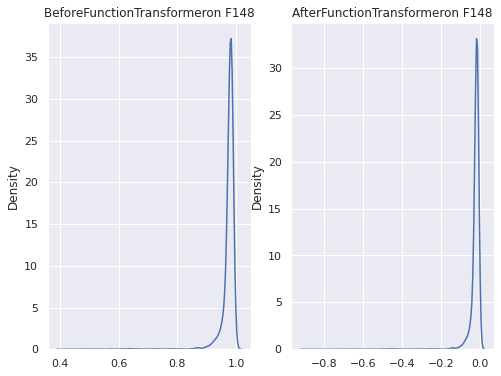

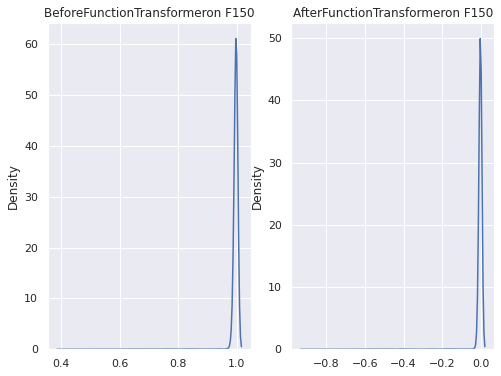

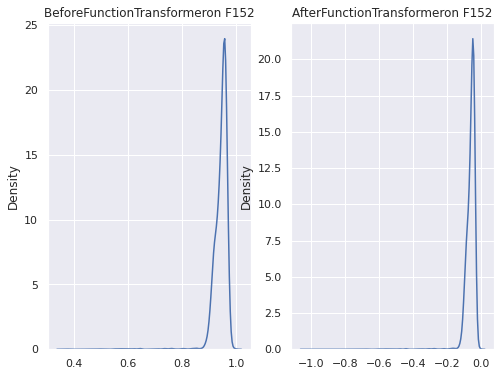

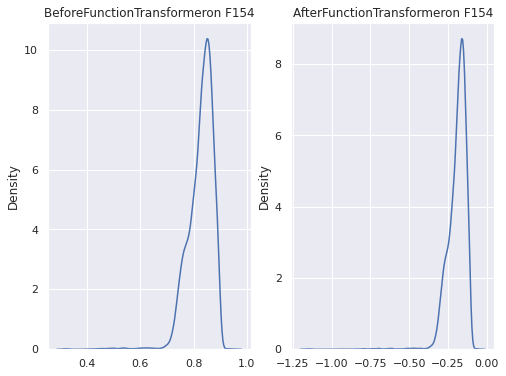

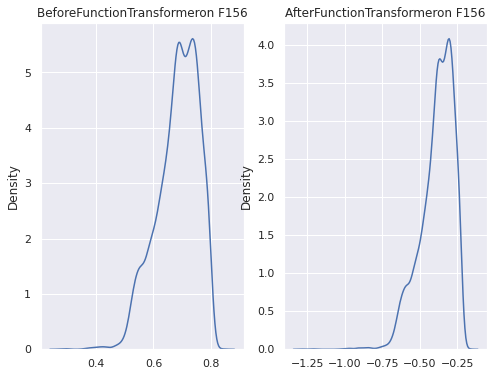

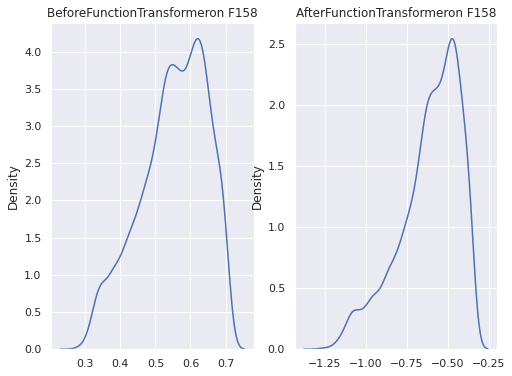

In [25]:
#Function Tranformer (We use log-transform !)
transform_and_plot(X_train_df, transformers[2], [140,160,2])

# Simple Machine Learning

In [26]:
def model_accuracy_scaled(model):
    model_scaled = Pipeline([
                             ('scale',QuantileTransformer(output_distribution='normal')),
                             ('model',model)
    ])
    model_scaled.fit(X_train,y_train)
    return model_scaled.score(X_test,y_test)

def model_accuracy_unscaled(model):
    model_unscaled = Pipeline([('model',model)])
    model_unscaled.fit(X_train,y_train)
    return model_unscaled.score(X_test,y_test)